In [22]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

np.random.seed(42) # semente escolhida

In [17]:
np.random.seed(42)
def simulacao_percolacao(N, p):
  ''' Recebe os parâmetros N (o tamanho da matriz será NxN) e p (probabilidade da entrada da matriz ser 1, e 0 caso contrário),
retorna se a matriz percolou, o número de clusters e o tamanho do maior cluster'''
  percolou = False
  maior_cluster = 0
  num_clusters = 0

  grade = np.random.rand(N, N) < p
  grade = np.where(grade, 1, 0)
  if not np.any(grade):
    return False, 0, 0
  # Se a matriz for inteiramente de zeros, já retorna que não percola e não teve clusters

  estrutura = ndimage.generate_binary_structure(rank=2, connectivity=1)
  # Define a estrutura de Vizinhos de von Neumann

  grade_clusters, num_clusters = ndimage.label(grade, estrutura)
  # Função de etiquetar as matrizes em clusters
  coluna_1 = grade_clusters[:, 0]
  coluna_n = grade_clusters[:, -1]
  linha_1 = grade_clusters[0]
  linha_n = grade_clusters[-1]

  intersecoes_vertical = np.intersect1d(linha_1, linha_n)
  intersecoes_horizontal = np.intersect1d(coluna_1, coluna_n)

  percolou_vertical = np.any(intersecoes_vertical > 0)
  percolou_horizontal = np.any(intersecoes_horizontal > 0)
  if percolou_vertical or percolou_horizontal:
    percolou = True

  grade_clusters_d1 = np.ravel(grade_clusters)

  contagem = np.bincount(grade_clusters_d1)
  # Conta ocupação de cada etiqueta de cluster
  maior_cluster = max(contagem[1:])
  # Maior cluster é o elemento que ocupou mais sítios (excluindo o zero)

  return percolou, maior_cluster, num_clusters

perc, maior, num = simulacao_percolacao(8, 0.5)
print(f"O sistema percolou? {perc}")
print(f"Qual o tamanho do maior cluster? {maior}")
print(f"Qual o número total de clusters? {num}")

O sistema percolou? False
Qual o tamanho do maior cluster? 15
Qual o número total de clusters? 6


In [18]:
np.random.seed(42)
def media_cluster(N, p, n):
  ''' Recebe os parâmetros N (o tamanho da matriz será NxN) e p (probabilidade da entrada da matriz ser 1, e 0 caso contrário), e
n (número de amostras que desejamos gerar) e retorna métricas tanto sobre percolação como sobre não percolação: listas contendo
os valores dos maiores clusters, a probabilidade de percolação/não percolação, a média dos maiores clusters e o total de cada tipo'''
  valores_percola = []
  valores_nao_percola = []
  total_percola, total_nao = 0,0
    
  for i in range(n):
    y = simulacao_percolacao(N, p)
    if y[0] == True:
      valores_percola.append(y[1])
      total_percola += 1
    else:
      valores_nao_percola.append(y[1])
      total_nao += 1

  prob_percola = len(valores_percola) / n
  prob_nao = 1 - prob_percola

  media_percola = sum(valores_percola) / len(valores_percola) if valores_percola else 0
  media_nao = sum(valores_nao_percola) / len(valores_nao_percola) if valores_nao_percola else 0
    
  return valores_percola, valores_nao_percola, prob_percola, prob_nao, media_percola, media_nao, total_percola, total_nao

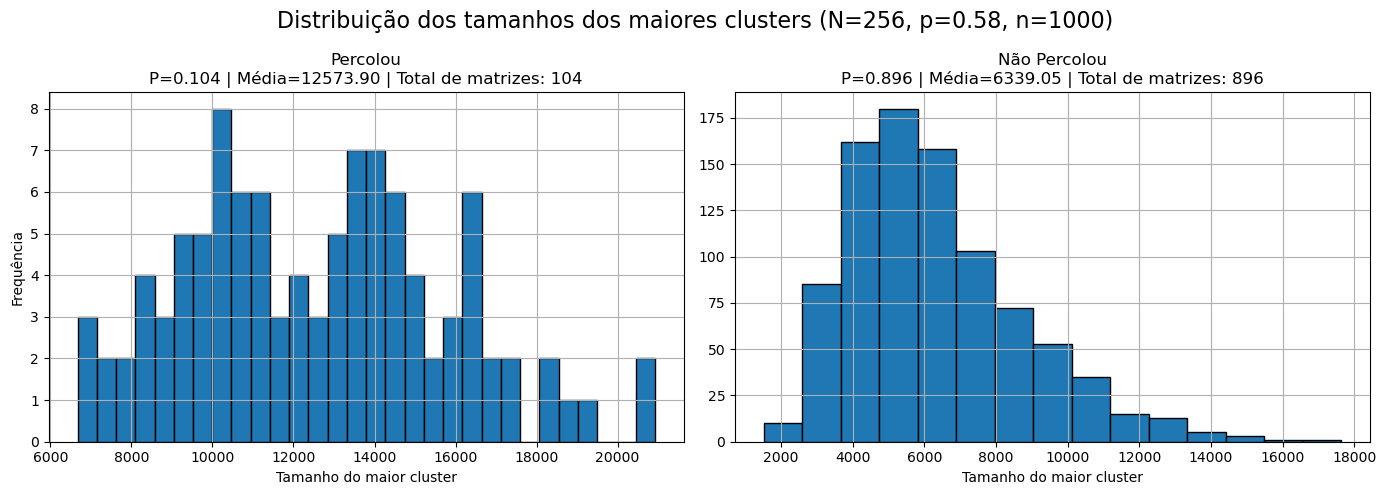

In [20]:
np.random.seed(42)
def grafico(N, p, n):
  '''Os parâmetros são os mesmos da função media_cluster(N, p, n). 
  Gera dois gráficos comparativos com as métricas dos sistemas/matrizes que percolam e que não percolam'''
  dados = media_cluster(N, p, n)
  valores_perc, valores_nao, prob, prob_nao, media_p, media_n, total_percola, total_nao = dados

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  # Histograma percolação
  axes[0].hist(valores_perc, bins=30, edgecolor='black')
  axes[0].set_title(f"Percolou\nP={prob:.3f} | Média={media_p:.2f} | Total de matrizes: {total_percola}")
  axes[0].set_xlabel("Tamanho do maior cluster")
  axes[0].set_ylabel("Frequência")
  axes[0].grid(True)

  # Histograma NÃO percolação
  axes[1].hist(valores_nao, bins=15, edgecolor='black')
  axes[1].set_title(f"Não Percolou\nP={prob_nao:.3f} | Média={media_n:.2f} | Total de matrizes: {total_nao}")
  axes[1].set_xlabel("Tamanho do maior cluster")
  axes[1].grid(True)

  plt.suptitle(f"Distribuição dos tamanhos dos maiores clusters (N={N}, p={p}, n={n})", fontsize=16)
  plt.tight_layout()
  plt.show()


grafico(256, 0.58, 1000)

In [30]:
np.random.seed(42)
erro = 0.1
N = 128
n = 500
def encontrar_limiar(N, n):
    def f(N, x, n):
        return media_cluster(N, x, n)[2]  # retorna valor

    a, b = 0, 1
    x = (a + b)/2
    iter = 0

    while abs(f(N, x, n)-0.5) > erro:
        resultado = f(N, x, n)
        if resultado < 0.5:
            a = x
        elif resultado > 0.5:
            b = x
        x = (a + b)/2
    return x

print(encontrar_limiar(128, 500))

0.5859375


[0.5625]
[0.5625, 0.578125]
[0.5625, 0.578125, 0.578125]
[0.5625, 0.578125, 0.578125, 0.5859375]
[0.5625, 0.578125, 0.578125, 0.5859375, 0.58984375]
[0.5625, 0.578125, 0.578125, 0.5859375, 0.58984375, 0.58984375]
[0.5625, 0.578125, 0.578125, 0.5859375, 0.58984375, 0.58984375, 0.591796875]


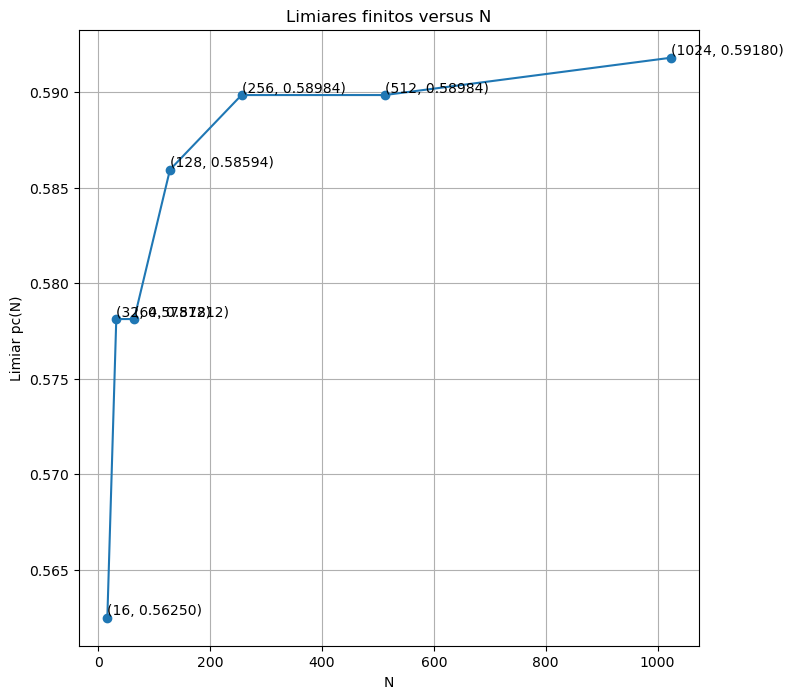

In [32]:
np.random.seed(42)
def limiar_critico(n, plotar=False):
  ''' Recebe como parâmetro o total de amostras (n) que vai rodar e retorna o gráfico com a intersecção entre
  os valores de N e seu limiar crítico empírico'''  
  lista_p = np.linspace(0.0, 1.0, 100)
  lista_N = [16, 32, 64, 128, 256, 512, 1024]
  lista_limiares = []

  for N in lista_N:
    x = encontrar_limiar(N, n)
    lista_limiares.append(x)
    print(lista_limiares)

  if plotar:
    plt.figure(figsize=(15,8))
    plt.xlabel('Probabilidade p')
    plt.ylabel('Probabilidade de Percolação θ(p)')
    plt.title(f'Curva de Percolação para N={N}')
    plt.axhline(0.5, color='red', linestyle='--', label='θ(p) = 0.5')
    plt.axvline(x, color='black', linestyle=':', label=f'p limiar para N={N} = {p_limiar:.3f}')
    plt.plot(lista_p, marker='o')
    plt.grid(True)
    plt.legend()
    plt.show()

  lista_1N = np.array(1 / np.array(lista_N))
  plt.figure(figsize=(8,8))
  plt.xlabel('N')
  plt.ylabel('Limiar pc(N)')
  plt.title(f'Limiares finitos versus N')
  plt.plot(lista_N, lista_limiares, marker='o')
  for x, y in zip(lista_N, lista_limiares):
    plt.text(x, y, f"({x}, {y:.5f})", ha='left', va='bottom')
  plt.grid(True)
  plt.show()
        
limiar_critico(500, False)